Once we have data in the format set-up by the new `heron.data` interface we'll want to use it to construct models.

In [1]:
from heron.data import DataWrapper
import gpytorch
import torch

In [2]:
data = DataWrapper("test_file_2.h5")

We can access the training data through the `get_training_data` interface on the datawrapper object.

In [3]:
import matplotlib.pyplot as plt

In [4]:
from heron.models.torchbased import HeronCUDA,  train

In [5]:
import numpy as np

In [6]:
model = HeronCUDA(datafile="test_file_2.h5", datalabel="IMR training linear", 
                  device=torch.device("cuda"),
                 )

torch.Size([5985, 2])


In [7]:
train(model, iterations=500)

/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=self.device, dtype=torch.float)


findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


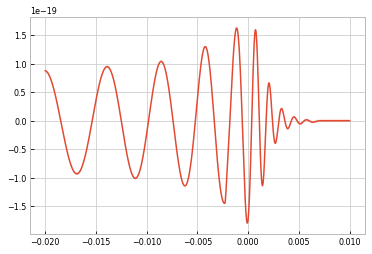

In [8]:
#lower, upper = observed_pred.confidence_region()
#with gpytorch.settings.max_cg_iterations(500):
preds = model.mean(times=1*np.linspace(-.02, 0.01, 1000), p={"mass ratio": 0.4}) #, p={"mass ratio":float(model.training_x[1,0])/100})
plt.plot(preds['plus'].times.cpu(), preds['plus'].data.cpu())
plt.fill_between(preds['plus'].times.cpu(), preds['plus'].data.cpu()+(preds['plus'].variance.cpu().detach()), preds['plus'].data.cpu()-(preds['plus'].variance.cpu().detach()), alpha=0.2)

/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=self.device, dtype=torch.float)
/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=self.device, dtype=torch.float)


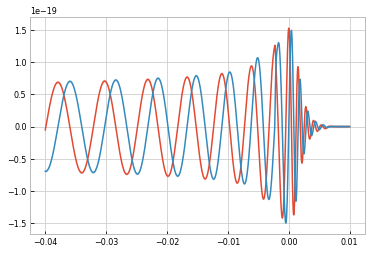

In [9]:
#lower, upper = observed_pred.confidence_region()
#with gpytorch.settings.max_cg_iterations(500):
q = 0.34
preds = model.mean(times=1*np.linspace(-.04, 0.01, 1000), p={"mass ratio": q}) #, p={"mass ratio":float(model.training_x[1,0])/100})
plt.plot(preds['plus'].times.cpu(), preds['plus'].data.cpu())
plt.fill_between(preds['plus'].times.cpu(), preds['plus'].data.cpu()+(preds['plus'].variance.cpu().detach()), preds['plus'].data.cpu()-(preds['plus'].variance.cpu().detach()), alpha=0.2)
#lower, upper = observed_pred.confidence_region()
#with gpytorch.settings.max_cg_iterations(500):
preds = model.mean(times=1*np.linspace(-.04, 0.01, 1000), p={"mass ratio": q}) #, p={"mass ratio":float(model.training_x[1,0])/100})
plt.plot(preds['cross'].times.cpu(), preds['cross'].data.cpu())
plt.fill_between(preds['cross'].times.cpu(), preds['cross'].data.cpu()+(preds['cross'].variance.cpu().detach()), preds['cross'].data.cpu()-(preds['cross'].variance.cpu().detach()), alpha=0.2)

In [10]:
from heron.likelihood import Match, Overlap, InnerProduct
from elk.catalogue import PPCatalogue

In [11]:
M = 20
imr_cat = PPCatalogue("IMRPhenomPv2", total_mass=M, fmin=10, )

In [12]:
for q in np.linspace(0.1, 1.0, 1):
    p = {"mass ratio": q}
    times=1*torch.linspace(-.005, 0.005, 70)
    a = model.mean(p=p, times=times)['plus']
    #print(a, type(a))
    b = model.mean(p=p, times=times)['plus']
    b = imr_cat.waveform(p, [-0.005, 0.005, 70])[0]
    a.times = a.times#*100
    matcher = Match(psd=None, duration=0.055, window=torch.blackman_window)
    over = Overlap(psd=None, duration=0.055, window=torch.blackman_window)
    b.data = torch.Tensor(b.data).cuda()
    match = matcher(a, b)
    print(match.abs().max())

/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=self.device, dtype=torch.float)


tensor(4.9720, device='cuda:0')


/home/daniel/repositories/ligo/heron/heron/likelihood.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.data = torch.tensor(b.data, device=a.data.device)


In [13]:
match.abs().max()

tensor(4.9720, device='cuda:0')

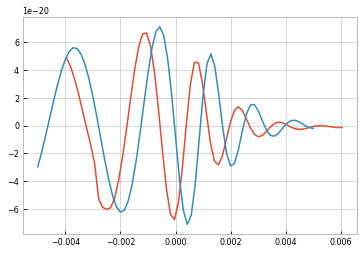

In [14]:
plt.plot(a.times-0.00065, a.data.cpu())
plt.plot(b.times, b.data.cpu())

In [15]:
import matplotlib.pyplot as plt

In [16]:
import gpytorch

In [17]:
#with gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cg_iterations(1500):
#    train(model, iterations=500)

In [18]:
for kernel in model.model_plus.covar_module.base_kernel.kernels:
    print(f"Dim: {kernel.active_dims}: {kernel.lengthscale.item():.3f}")

Dim: 1: 0.023
Dim: 0: 2.266


In [19]:
#train(model, iterations=5000)

In [20]:
import torch

In [21]:
from elk.waveform import Timeseries, FrequencySeries

In [22]:
from heron.likelihood import CUDALikelihood, InnerProduct

In [23]:
q = 0.2
noise = 5e-19*torch.randn(251, device="cuda")
times = torch.linspace(-0.05, 0.005, 501)
signal = model.frequency_domain_waveform(times=times, p={"mass ratio": q}, window=torch.blackman_window)
#model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": q})

detection = FrequencySeries(data=(torch.tensor(signal['plus'].data, device="cuda") + noise), frequencies=signal['plus'].frequencies)
#detection = signal['plus']
#plt.plot(detection.times.cpu(), detection.data.cpu())
#signal = {'plus': torch.zeros(501, device="cuda")}
#plt.plot(signal['plus'].times.cpu(), signal['plus'].data.cpu())

#plt.show()

l = CUDALikelihood(model, 
                   data=detection,
                   psd=5e-19*torch.ones(251, device='cuda'),
                   window=torch.blackman_window,
                   detector_prefix="H1",
                   start=-0.05
                  )

masses = np.linspace(0.01,1.0,100)

likes = torch.tensor([l({'mass ratio': m, 'ra': 0, 'dec': 0., 'psi':0, 'gpstime':0}, model_var=True).cpu() for m in masses])
likes2 = torch.tensor([l({'mass ratio': m, 'ra': 0., 'dec': 0., 'psi':0, 'gpstime':0}, model_var=False).cpu() for m in masses])

/home/daniel/repositories/ligo/heron/heron/models/torchbased.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(points, device=self.device, dtype=torch.float)
/home/daniel/repositories/ligo/elk/elk/waveform.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  variance_f = torch.fft.rfft(window(len(self.data), device=self.data.device)*torch.tensor(self.variance))
/tmp/ipykernel_30435/430841077.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  detection = FrequencySeries(data=(torch.tensor(signal['plus'].data, de

AttributeError: 'NoneType' object has no attribute 'abs'

In [ ]:
p = {'mass ratio': 0.5, 'ra': 0.5, 'dec': 0.1, 'psi':0, 'gpstime':0}

In [ ]:
len(l._call_model(p)['plus'].data)

In [ ]:
f, ax = plt.subplots(1,1, dpi=300)
ax.plot(masses, likes, label="With waveform variance")
ax.plot(masses, likes2, label="No waveform variance")
ax.axvline(q, c='orange', label="Injected q")
ax.set_xlabel("Mass ratio")
ax.set_ylabel("Log Likelihood")
ax.legend()

In [ ]:
masses = np.linspace(0.1,1.0,100)
likes = torch.tensor([l._products({'mass ratio': m}, model_var=True).cpu() for m in masses])
likes2 = torch.tensor([l._products({'mass ratio': m}, model_var=False).cpu() for m in masses])

In [ ]:
torch.logdet(torch.diag(l.psd.abs()))

In [ ]:
signal = model.frequency_domain_waveform(times=torch.linspace(-.05, 0.005, 501), p={"mass ratio": q}, window=torch.blackman_window)

In [ ]:
torch.logdet(torch.diag(signal['plus'].variance + l.psd).real)

In [ ]:
torch.logdet(torch.diag(signal['plus'].variance + l.psd).abs())

In [ ]:
ip = InnerProduct(psd=5e-21*torch.ones(251, device='cuda'),
             duration=times[-1] - times[0])

In [ ]:
q = 0.7
noise = 5e-21*torch.randn(501, device="cuda")
signal = model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": q})

detection = Timeseries(data=(torch.tensor(signal['plus'].data, device="cuda") + noise), times=signal['plus'].times)

plt.plot(detection.times.cpu(), detection.data.cpu())
signal = {'plus': torch.zeros(501, device="cuda")}
#plt.plot(signal['plus'].times.cpu(), signal['plus'].data.cpu())
ip(torch.fft.rfft(signal['plus']), torch.fft.rfft(detection.data))

In [ ]:
hoff = model.frequency_domain_waveform(times=torch.linspace(-.05, 0.005, 501), p={"mass ratio": q}, window=torch.blackman_window)

In [ ]:
hoft = model.time_domain_waveform(times=torch.linspace(-.05, 0.005, 501), p={"mass ratio": q})

In [ ]:
q = 0.7
noise = 5e-21*torch.randn(501, device="cuda")
signal = model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": q})

detection = Timeseries(data=(torch.tensor(signal['plus'].data, device="cuda") + noise), times=signal['plus'].times)

#plt.plot(detection.times.cpu(), detection.data.cpu())
#signal = {'plus': torch.zeros(501, device="cuda")}
#plt.plot(signal['plus'].times.cpu(), signal['plus'].data.cpu())
ip(torch.fft.rfft(signal['plus'].data), torch.fft.rfft(signal['plus'].data))

In [ ]:
ips = []
for q in np.linspace(0.1, 0.9, 100):
    template = model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": 0.7})
    signal = model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": q})
    ips.append(ip(torch.fft.rfft(torch.blackman_window(501, device="cuda")*template['plus'].data), torch.fft.rfft(torch.blackman_window(501, device="cuda")*signal['plus'].data)).cpu())
    

In [ ]:
plt.plot(np.linspace(0.1, 0.9, 100), ips)

+ -0.5 (h|h) + (h|d) = 0.5 (h|h) if d == h
+ Test with zero noise first

In [ ]:
ips = []
for q in np.linspace(0.1, 0.9, 100):
    template = model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": 0.7})
    signal = model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": q})
    ips.append(ip(torch.fft.rfft(torch.blackman_window(501, device="cuda")*signal['plus'].data), torch.fft.rfft(torch.blackman_window(501, device="cuda")*template['plus'].data)).cpu())
    

In [ ]:
plt.plot(np.linspace(0.1, 0.9, 100), ips)

In [ ]:
ips = []
for q in np.linspace(0.1, 0.9, 100):
    template = model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": 0.7})
    signal = model.time_domain_waveform(times=np.linspace(-.05, 0.005, 501), p={"mass ratio": q})
    ips.append(ip(signal['plus'].to_frequencyseries().data, template['plus'].to_frequencyseries().data).cpu())
    

In [ ]:
plt.plot(np.linspace(0.1, 0.9, 100), ips)

In [ ]:


torch.abs(torch.fft.rfft(signal['plus'].data)**2 / 5e-21*torch.ones(251, device='cuda')**2).sum()

In [ ]:
plt.plot(noise.cpu())

In [ ]:
plt.plot(torch.fft.rfft(noise.cpu()))

In [ ]:
#plt.plot(masses, likes)
plt.plot(masses, likes2)